# 01 - Data Overview

Overview of datasets and metrics for simplicity evaluation.

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

from src.data_loader import load_all_datasets, get_metric_names, get_dataset_summary

plt.style.use('seaborn-v0_8-whitegrid')
print('Setup complete!')

Setup complete!


## 1. Dataset Summary

In [2]:
summary = get_dataset_summary()
display(summary)

Loading all datasets...

ARTS:
  ARTS94: 94 samples, 10 metrics
  ARTS300: 300 samples, 10 metrics
  ARTS3k: 2999 samples, 10 metrics

LR-ARTS (Length-Residualized):
  LR-ARTS94: 94 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS300: 300 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS3k: 2999 samples, 10 metrics [LENGTH-RESIDUALIZED]

SDA:
  SDA: 600 samples, 26 metrics

Human-annotated:
  ST-sent: 1620 samples, 26 metrics, scale (1, 7)
  ST-para: 271 samples, 26 metrics, scale (1, 7)
  D-Wiki: 601 samples, 26 metrics, scale (1, 5)


,Dataset,Samples,Metrics,Score Range,Scale
0,ARTS94,94,10,"[0.00, 1.00]","(0, 1)"
1,ARTS300,300,10,"[0.00, 1.00]","(0, 1)"
2,ARTS3k,2999,10,"[0.00, 1.00]","(0, 1)"
3,LR-ARTS94,94,10,"[-0.41, 0.59]","(0, 1)"
4,LR-ARTS300,300,10,"[-0.58, 0.60]","(0, 1)"
5,LR-ARTS3k,2999,10,"[-0.78, 0.73]","(0, 1)"
6,SDA,600,26,"[2.13, 94.93]",None
7,ST-sent,1620,26,"[1.50, 7.00]","(1, 7)"
8,ST-para,271,26,"[2.83, 7.00]","(1, 7)"
9,D-Wiki,601,26,"[1.00, 5.00]","(1, 5)"


## 2. Load All Datasets

In [3]:
datasets = load_all_datasets()

Loading all datasets...

ARTS:
  ARTS94: 94 samples, 10 metrics
  ARTS300: 300 samples, 10 metrics
  ARTS3k: 2999 samples, 10 metrics

LR-ARTS (Length-Residualized):
  LR-ARTS94: 94 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS300: 300 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS3k: 2999 samples, 10 metrics [LENGTH-RESIDUALIZED]

SDA:
  SDA: 600 samples, 26 metrics

Human-annotated:
  ST-sent: 1620 samples, 26 metrics, scale (1, 7)
  ST-para: 271 samples, 26 metrics, scale (1, 7)
  D-Wiki: 601 samples, 26 metrics, scale (1, 5)


## 3. Available Metrics

In [4]:
print('Available Metrics per Dataset:')
print('=' * 60)
for name, data in datasets.items():
    metrics = get_metric_names(data)
    print(f'\n{name} ({data["n_samples"]} samples):')
    print(f'  {len(metrics)} metrics: {metrics}')

Available Metrics per Dataset:

ARTS94 (94 samples):
  10 metrics: ['SLE', 'FKGL', 'Word_Count', 'Avg_Word_Len', 'BATS-GB', 'BATS-RF', 'Claude(simp)', 'Ours_RF', 'Random', 'Shuffle']

ARTS300 (300 samples):
  10 metrics: ['SLE', 'FKGL', 'Word_Count', 'Avg_Word_Len', 'BATS-GB', 'BATS-RF', 'Claude(simp)', 'Ours_RF', 'Random', 'Shuffle']

ARTS3k (2999 samples):
  10 metrics: ['SLE', 'FKGL', 'Word_Count', 'Avg_Word_Len', 'Claude(simp)', 'Random', 'Shuffle', 'Ours_RF', 'BATS-GB', 'BATS-RF']

LR-ARTS94 (94 samples):
  10 metrics: ['SLE', 'FKGL', 'Word_Count', 'Avg_Word_Len', 'BATS-GB', 'BATS-RF', 'Claude(simp)', 'Ours_RF', 'Random', 'Shuffle']

LR-ARTS300 (300 samples):
  10 metrics: ['SLE', 'FKGL', 'Word_Count', 'Avg_Word_Len', 'BATS-GB', 'BATS-RF', 'Claude(simp)', 'Ours_RF', 'Random', 'Shuffle']

LR-ARTS3k (2999 samples):
  10 metrics: ['SLE', 'FKGL', 'Word_Count', 'Avg_Word_Len', 'Claude(simp)', 'Random', 'Shuffle', 'Ours_RF', 'BATS-GB', 'BATS-RF']

SDA (600 samples):
  26 metrics: ['FKGL

## 4. Human Score Distributions

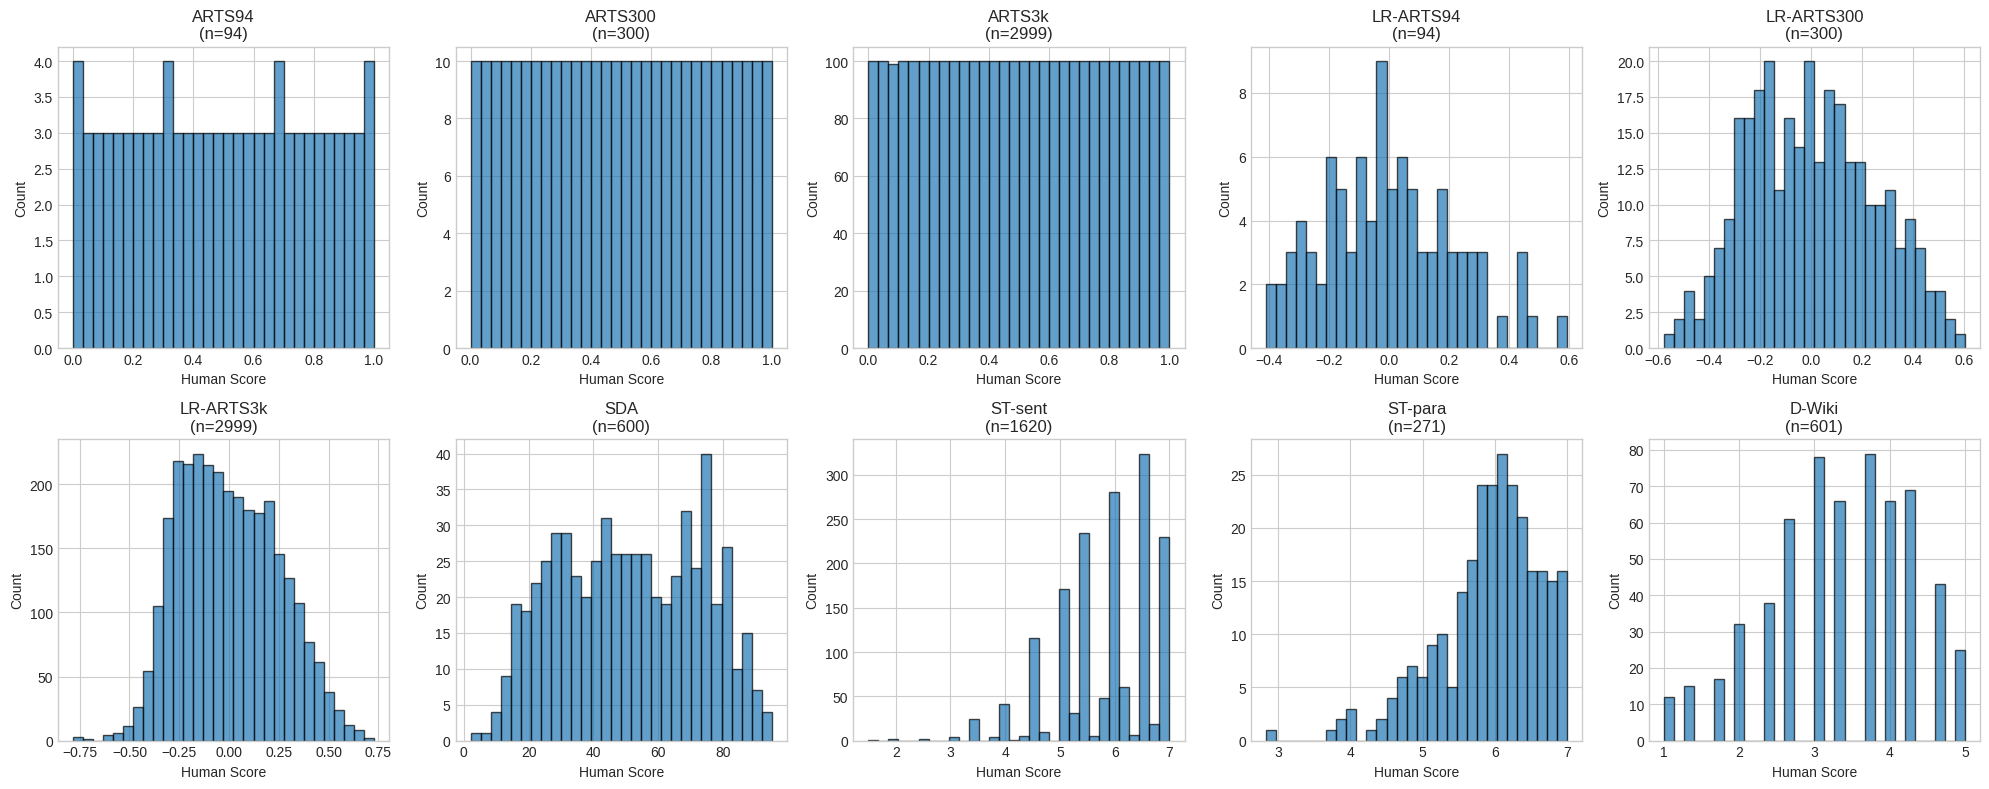

In [5]:
# Dynamic grid based on number of datasets
n_datasets = len(datasets)
n_cols = 5
n_rows = (n_datasets + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for i, (name, data) in enumerate(datasets.items()):
    ax = axes[i]
    human = data['human_scores']
    ax.hist(human, bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'{name}\n(n={len(human)})')
    ax.set_xlabel('Human Score')
    ax.set_ylabel('Count')

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## 5. Metric Correlations with Human Scores

In [6]:
# Compute correlations for all datasets
all_correlations = []

for dataset_name, data in datasets.items():
    human = data['human_scores']
    metrics = data['metric_scores']
    
    for metric_name, scores in metrics.items():
        if metric_name == 'human':
            continue
        
        # Handle NaN
        mask = ~(np.isnan(human) | np.isnan(scores))
        if mask.sum() < 10:
            continue
        
        r_p, _ = pearsonr(human[mask], scores[mask])
        r_s, _ = spearmanr(human[mask], scores[mask])
        
        all_correlations.append({
            'Dataset': dataset_name,
            'Metric': metric_name,
            'Pearson': r_p,
            'Spearman': r_s,
            'N': mask.sum(),
        })

corr_df = pd.DataFrame(all_correlations)
print(f'Total: {len(corr_df)} metric-dataset combinations')

Total: 164 metric-dataset combinations


In [7]:
# Pivot to show metrics x datasets
pivot_pearson = corr_df.pivot(index='Metric', columns='Dataset', values='Pearson')
col_order = ['ARTS94', 'ARTS300', 'ARTS3k', 'LR-ARTS94', 'LR-ARTS300', 'LR-ARTS3k', 'SDA', 'ST-sent', 'ST-para', 'D-Wiki']
col_order = [c for c in col_order if c in pivot_pearson.columns]
pivot_pearson = pivot_pearson.reindex(columns=col_order)

print('Pearson Correlations (Metric vs Human):')
display(pivot_pearson.round(3))

Pearson Correlations (Metric vs Human):


Dataset,ARTS94,ARTS300,ARTS3k,LR-ARTS94,LR-ARTS300,LR-ARTS3k,SDA,ST-sent,ST-para,D-Wiki
Metric,,,,,,,,,,
Avg_Word_Len,0.319,0.023,0.149,0.407,0.151,0.231,0.067,0.002,0.174,0.058
BATS-GB,0.774,0.662,0.424,0.323,0.270,0.204,0.196,0.667,0.185,0.555
BATS-RF,0.737,0.655,0.442,0.268,0.273,0.202,0.188,0.676,0.181,0.608
BERTScore_P,NaN,NaN,NaN,NaN,NaN,NaN,0.567,-0.164,-0.063,0.389
BLEU,NaN,NaN,NaN,NaN,NaN,NaN,0.255,-0.348,-0.228,0.058
Claude(simp),-0.682,-0.727,-0.688,-0.468,-0.578,-0.559,0.363,0.465,0.297,0.495
Claude(simp+ref),NaN,NaN,NaN,NaN,NaN,NaN,0.639,0.026,0.154,0.497
Claude(simp+src),NaN,NaN,NaN,NaN,NaN,NaN,0.676,0.179,0.216,0.574
Claude(simp+src+ref),NaN,NaN,NaN,NaN,NaN,NaN,0.725,0.181,0.188,0.522


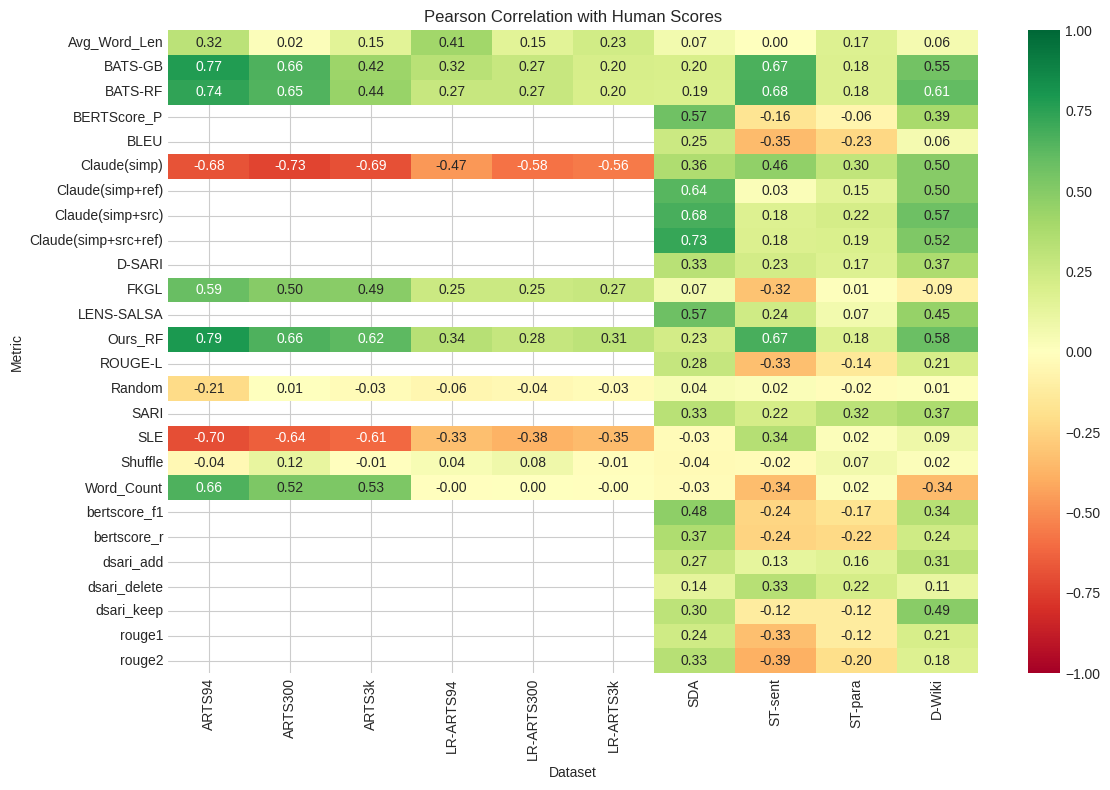

In [8]:
# Heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_pearson, annot=True, fmt='.2f', cmap='RdYlGn', center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('Pearson Correlation with Human Scores')
plt.tight_layout()
plt.show()

## 6. Summary

- 10 datasets: 7 original + 3 length-residualized (LR-ARTS)
- 8-30 metrics evaluated per dataset
- Metrics include: baselines (Random, Shuffle), readability (FKGL, Word_Count), neural (SLE, LENS-SALSA, BATS), LLMs (Claude)